# Using Copernicus Data Space Ecosystem with Sentinel Hub APIs: examples with Sentinel 3 and the Global Human Settlement dataset from a external provider

In this notebook, we will show how this whole process of getting analysis-ready data into Python can be sped up by using the Copernicus Dataspace Ecosystem and Sentinel Hub APIs. This is being presented by running through two use cases handling brightness temperature from Sentinel 3, and the built-up srface area layer of the Global Human Settlement dataset. The notebook uses the popular [xarray](https://docs.xarray.dev/en/stable/index.html#) Python library to handle the multidimensional data or data cubes.

What we show in this notebook:

- How to access Sentinel 3 data in the Copernicus Dataspace Ecosystem
- Calculation of mean values and statistics
- Importing a BYOC dataset in the Copernicus Dataspace Ecosystem 
- Creating a time series
- Loading data into xarray
- Basic classification using thresholding

## Prerequisites

- [A Copernicus Dataspace Ecosystem account](https://documentation.dataspace.copernicus.eu/Registration.html)
- Basic understanding of the Sentinel Hub Processing API ([Introductory Notebook available here](https://documentation.dataspace.copernicus.eu/notebook-samples/sentinelhub/data_download_process_request.html))

## Imports
Import the Sentinel Hub package and additional libraries.

The Sentinel Hub API is a RESTful API interface that provides access to various satellite imagery archives. It allows you to access raw satellite data, rendered images, statistical analysis, and other features.

In [217]:
# Utilities
from pathlib import Path
import matplotlib.pyplot as plt
from datetime import datetime
#import pandas as pd
import getpass
import geopandas as gpd
import rasterio
import rasterio.plot
import numpy as np
import xarray as xr

from sentinelhub import (
    SHConfig,
    DataCollection,
    SentinelHubCatalog,
    SentinelHubRequest,
    SentinelHubStatistical,
    BBox,
    bbox_to_dimensions,
    CRS,
    MimeType,
    Geometry,
    SentinelHubDownloadClient,
)



### Credentials

To obtain your `client_id` & `client_secret`, you need to navigate to your [Dashboard](https://shapps.dataspace.copernicus.eu/dashboard/#/). In the User Settings, you can create a new OAuth client to generate these credentials. More detailed instructions can be found on the corresponding [documentation page](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Overview/Authentication.html).

Now that you have your `client_id` & `client_secret`, it is recommended to configure a new profile in your Sentinel Hub Python package. Instructions on how to configure your Sentinel Hub Python package can be found [here](https://sentinelhub-py.readthedocs.io/en/latest/configure.html). Following these instructions, you can create a profile specifically for using the package to access Copernicus Data Space Ecosystem data collections. This is useful as changes to the config class in your notebook are usually only temporary and by saving the configuration to your profile, you don't have to generate new credentials or overwrite/change the default profile every time you run or write a new Jupyter Notebook. 

If you are using the Sentinel Hub Python package for the Copernicus Data Space Ecosystem for the first time, you should create a profile specifically for the Copernicus Data Space Ecosystem. You can do this in the following cell:

In [158]:
# Only run this cell if you have not created a configuration.

config = SHConfig()
#config.sh_client_id = getpass.getpass("Enter your SentinelHub client id")
#config.sh_client_secret = getpass.getpass("Enter your SentinelHub client secret")
config.sh_token_url = "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token"
config.sh_base_url = "https://sh.dataspace.copernicus.eu"
#config.save("cdse")

Enter your SentinelHub client id ········
Enter your SentinelHub client secret ········


However, if you have already configured a profile in Sentinel Hub Python for the Copernicus Data Space Ecosystem, then you can run the below cell entering the profile name as a string replacing `cdse`.

In [261]:
#config = SHConfig("cdse")

## Area of Interest 

First, we define an area of interest. In this case the area of interest is Istanbul and its surroundings. 

The resolution is defined in the units of the coordinate reference system. Because we want to define units in meters, we also need to define the bounding box coordinates in a CRS using meters. We use EPSG:3035 in this case. This CRS is only available for Europe, outside of Europe we could use EPSG:3857 or UTM Zones.

You can also explore the area of interest in the Copernicus Browser [here](https://link.dataspace.copernicus.eu/5t1).

In [160]:
# Desired resolution of our data
resolution = (1000, 1000)
bbox_coords = [28.566742,40.820321,29.408569,41.337654]
epsg = 3035
# Convert to 3035 to get crs with meters as units
bbox = BBox(bbox_coords, CRS(4326)).transform(epsg)

## Data Access
For the first example we are going to use Sentinel-3 SLSTR data, in particular the F1 brightness temperature band. The spatial resolution of the data is 1000 m. For more information about Sentinel-3 SLSTR, check [here](https://docs.sentinel-hub.com/api/latest/data/sentinel-3-slstr-l1b/). 

Next, we define our [evalscript](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Evalscript.html). The evalscript is a piece of JavaScript code that tells the Copernicus Dataspace Ecosystem how to process the pixels you request before they are delivered to you.

For inspiration on what can be done in an evalscript, there is an extensive online resource of community-created evalscripts called [custom-scripts](https://custom-scripts.sentinel-hub.com/). In this example, we want to look at the values given by the F1 band.

In [161]:
# We also need to define the evalscript as a Python variable
evalscript_raw = """
//VERSION=3
function setup() {
   return {
    input: ["F1"], // This specifies the bands that are looked at
    output: { 
      bands: 1,
      // This specifies in which data type the values will be returned
      sampleType: "UINT16"
    },
    // Will make a simple mosaic, taking the most recent tiles to fill the bounding box
    mosaicking: "SIMPLE"
  };
}

function evaluatePixel(samples) {
    // Here we could do more calculations which are applied to each pixel, 
    // but for now let's just return the value 
   return [samples.F1-273] //Returns values in K
}
"""

With the evalscript we can now make a request for data.

The request will take care of a lot of things for us. It will return oue data itheur specified resoluti,nd bounding boxanded time ran.x.

In [ ]:
# This is defining the data we will use.
# You can list all available data collections with `DataCollection.get_available_collections()`.
data_l8 = DataCollection.SENTINEL3_SLSTR.define_from(name="s3slstr", service_url=config.sh_base_url)

request_raw = SentinelHubRequest(
    evalscript=evalscript_raw,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=data_l8,
            time_interval=("2023-06-09", "2024-06-09"),
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
    bbox=bbox,
    # Resolution is defined in units of the bbox crs! Be careful with WGS84 since this will be in degrees!
    # Since we have defined our bounding box in Web mercator the resolution is in meters.
    resolution=resolution, #It was already defined
    config=config,
    data_folder="./data",  # We save the data in a specified folder
)

After we've defined the request, we can get the data:

In [164]:
raw_data = request_raw.get_data(save_data=True)

Now we define a function which plots the data of the request together with the borders of the European countries, taken from the natural earth dataset.

In [165]:
countries = (
    gpd.read_file("./data/ne_50m_admin_0_countries/ne_50m_admin_0_countries.shp")
    .to_crs(3035)
    .cx[bbox.min_x : bbox.max_x, bbox.min_y : bbox.max_y]
    .reset_index(drop=True)
)
countries = countries[["ADMIN", "geometry"]]


def plot_request(request, bbox):
    image_path = Path(request.data_folder) / request.get_filename_list()[0]
    with rasterio.open(image_path) as raster:
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.set_xlim([bbox.min_x, bbox.max_x])
        ax.set_ylim([bbox.min_y, bbox.max_y])
        rasterio.plot.show(raster, ax=ax)
        countries.plot(ax=ax, facecolor="none", edgecolor="black")
        cbar = plt.colorbar(rasterio.plot.show(raster, ax=ax).get_images()[0], ax=ax, orientation='vertical')
        cbar.set_label('Celsius')

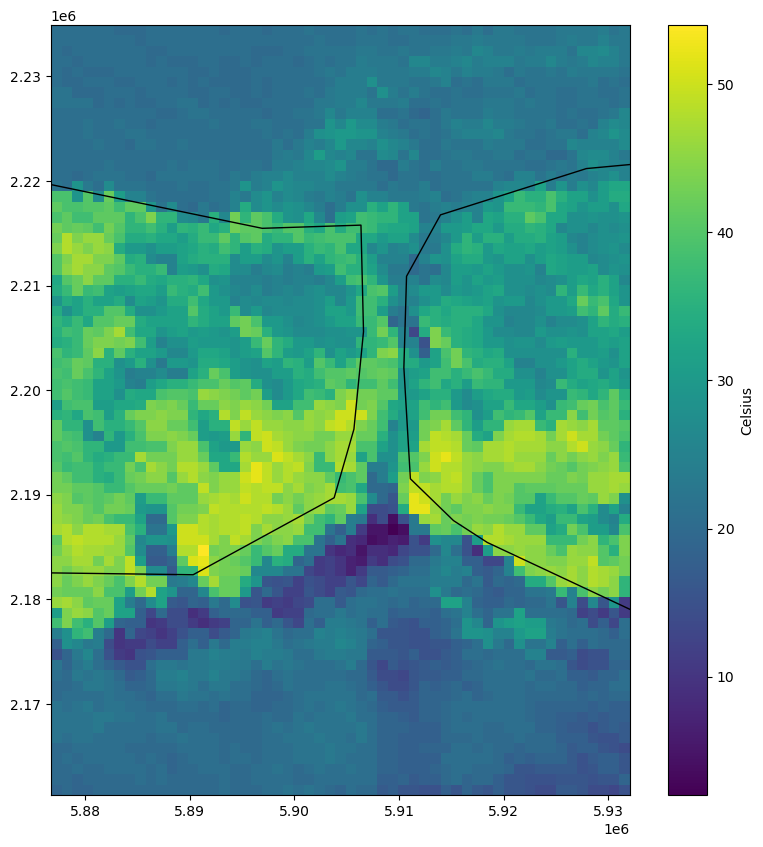

In [166]:
plot_request(request_raw, bbox)

# Obtaining statistics with statistical API

An updated script is created with the following changes:

The most important thing that changed is that we now changed the mosaicking input to ORBIT. This gives us all acquisitions for a time series to calculate values from. In the input we also have added `dataMask` as a band. This will tell us, if the NO2 band has data or not. We are using this to remove acquisitions without data from our calculation.

In our `evaluatePixel` function we have added two more steps. The first one is to filter out all acquisitions which do not have data with the `isClear()` function. After we have filtered the time series we can calculate the mean of all values using the `sum()` function and the length of the clear timeseries.

In the end we return the mean value we have calculated.

In [172]:
evalscript_mean_mosaic = """
//VERSION=3
function setup() {
    return {
        input: ["F1", "dataMask"],
        output: {
            bands: 1,
            sampleType: "FLOAT32",
        },
        mosaicking: "ORBIT"
    };
}

function isClear(sample) {
    return sample.dataMask == 1;
}

function sum(array) {
    let sum = 0;
    for (let i = 0; i < array.length; i++) {
        sum += array[i].F1; //Reduce 273 from F1 value
    }
    return sum;
}

function evaluatePixel(samples) {
    const clearTs = samples.filter(isClear)
    const mean = sum(clearTs) / clearTs.length
    return [mean-273]
}
"""

In [186]:
request_monthly = SentinelHubRequest(
    evalscript=evalscript_mean_mosaic,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=data_l8,
            time_interval=("2023-07-01", "2023-08-01"),
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
    bbox=bbox,
    resolution=(1000, 1000),
    config=config,
    data_folder="./data",
)

We now made a request for an entire month of data, for December of 2022. Other than that nothing much changed in the request.

In [187]:
mean_data = request_monthly.get_data(save_data=True)

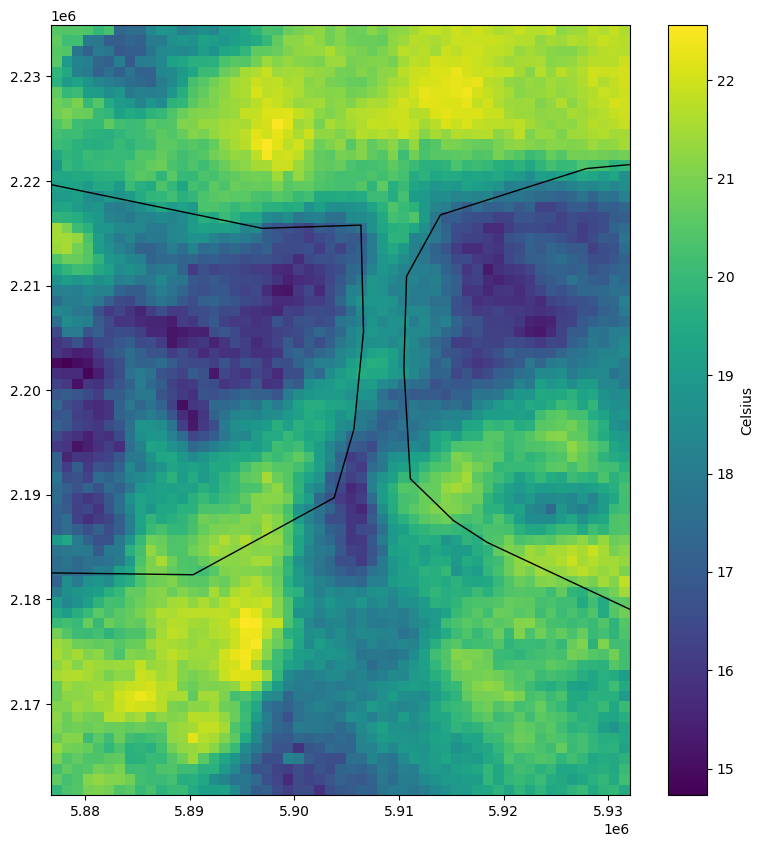

In [188]:
plot_request(request_monthly, bbox)

And a histogram can show how the values are distributed.

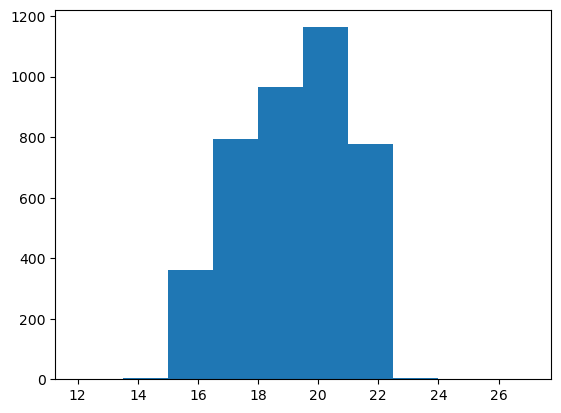

In [191]:
plt.stairs(*np.histogram(mean_data[0], range=(12, 27), bins=10), fill=True);

## Import Global Human Settlement collection
Copernicus Data Space Ecosystem allows users to upload their own data in a [Cloud Optimized Geotiff (COG)](https://www.cogeo.org/) format, ingesting it with the [Bring Your Own COG ("BYOC") API](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Byoc.html). Once a dataset is ingested, in can be made available privately or publicly, and other Sentinel Hub API requests can access the data collection via its BYOC collection ID ([example here](https://github.com/eu-cdse/notebook-samples/blob/main/sentinelhub/cloudless_process_api.ipynb)).
Here we also define a simple evalscript that returns values of the Built-up surface, Global Human Settlement layer directly from the dataset.

In [256]:
evalscript = """
//VERSION=3
function setup() {
  return {
    input: ["GHS_BUILT_S", "dataMask"],
    output: { bands: 1, sampleType: "UINT16" },
  };
}

function evaluatePixel(samples) {
  return [samples.GHS_BUILT_S];
}
"""

The bounding box, coordinate reference system, and spatial resolution is now defined. The original spatial resolution of the data is 100 m.

In [257]:
#time_interval=("2010-01-01", "2010-01-02")
bbox_coords = [28.566742,40.820321,29.408569,41.337654]
epsg = 3035
# Convert to 3035 to get crs with meters as units
bbox = BBox(bbox_coords, CRS(4326)).transform(epsg)
resolution = (100,100)

Then we define a Sentinel Hub Process API request that calls data from the custom BYOC collection holding the built-up surface data. 

In [258]:
ghs_collection = DataCollection.define_byoc(
    "379e04b9-c6cf-4561-b9e9-291ea1aa4c2c", service_url=config.sh_base_url
)
ghs_request = SentinelHubRequest(
    evalscript=evalscript,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=ghs_collection,
            time_interval=time_interval,
         #   mosaicking_order=MosaickingOrder.MOST_RECENT,
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
    bbox=bbox,
    resolution=resolution,
    config=config,
    data_folder="./data",
)

We collect raster built-up surface data of the area of interest and timeframe from the Process API request into a the variable `human_settlement`.

In [259]:
human_settlement = ghs_request.get_data(save_data=True)[0]

We visualize an image of the `human_settlement`variable using pyplot.

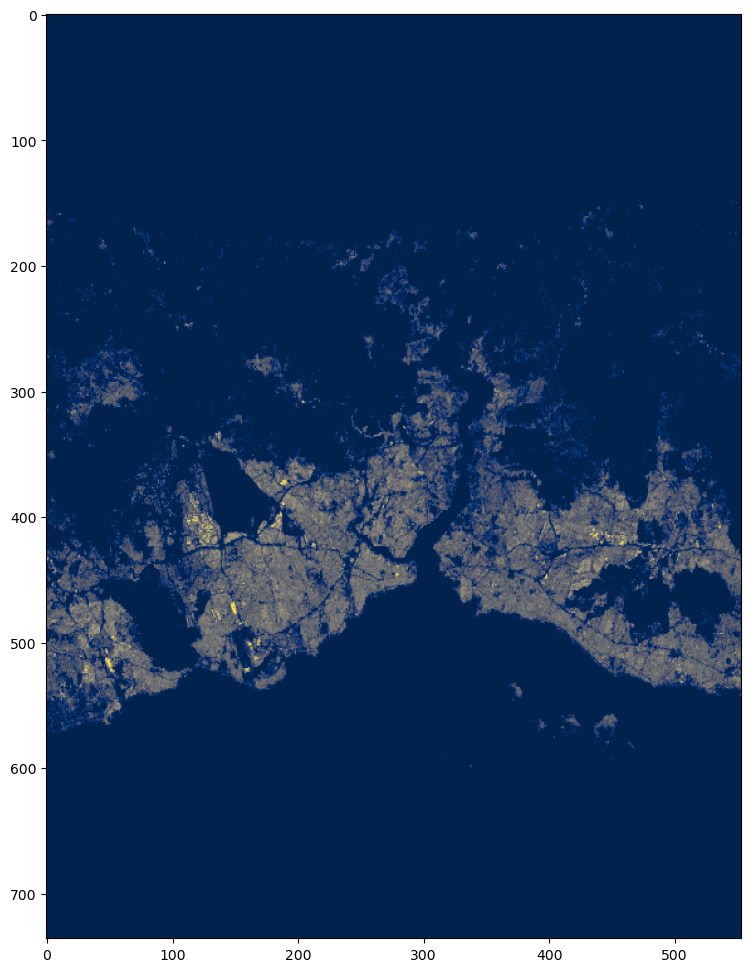

In [260]:
plt.figure(figsize=(12, 12))
plt.imshow(human_settlement, cmap="cividis");

This image shows the built-up surface patterns of Istanbul and its surroundings. 

We have requested imagery for one year, but now we will build a time series and see changes over the years.We do this by defining the period (2010-2030) in the `interval_of_interest()` function. Then we define a function `get_request()`, which will build the request to the Sentinel Hub API on the Copernicus Data Space Ecosystem.

In this [`SentinelHubRequest`](https://sentinelhub-py.readthedocs.io/en/latest/reference/sentinelhub.api.process.html#sentinelhub.api.process.SentinelHubRequest), we define the input data, the timeframe, the output type (TIFF), the bounding box, the resolution and where to save the data.

We define this as a function because we want to make several requests with the changing years being the only input. 

In [222]:
def interval_of_interest(year):
    return (datetime(year, 1, 1), datetime(year, 1, 1))


def get_request(year):
    time_interval = interval_of_interest(year)
    return SentinelHubRequest(
        evalscript=evalscript,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.define_byoc(
                    "379e04b9-c6cf-4561-b9e9-291ea1aa4c2c", service_url=config.sh_base_url),
                time_interval=time_interval,
            )
        ],
        responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
        bbox=bbox,
        resolution=resolution,
        config=config,
        data_folder="./data-ghs",
    )

This cell now creates a request for each of the years, from 2010 to 2030.

In [223]:
# create a dictionary of requests
sh_requests = {}
for year in range(2010, 2031,5):
    sh_requests[year] = get_request(year)

sh_requests

{2010: <sentinelhub.api.process.SentinelHubRequest at 0x7f8cd75568c0>,
 2015: <sentinelhub.api.process.SentinelHubRequest at 0x7f8cd7556470>,
 2020: <sentinelhub.api.process.SentinelHubRequest at 0x7f8cd7557460>,
 2025: <sentinelhub.api.process.SentinelHubRequest at 0x7f8cd7557220>,
 2030: <sentinelhub.api.process.SentinelHubRequest at 0x7f8cd7556860>}

The next step is to download the data. This is done with the utility function `SentinelHubDownloadClient`. It downloads a list of requests in parallel, greatly improving the download speed. Before we can do that, we need to change the format of the requests slightly, which is done in the variable `list_of_requests`.

In [224]:
list_of_requests = [request.download_list[0] for request in sh_requests.values()]

# download data with multiple threads
data = SentinelHubDownloadClient(config=config).download(
    list_of_requests, max_threads=5
)

The output of the requests do not provide any information about which year the data is from, so we rename the output of each request to the year of the data it represents.

In [225]:
def request_output_path(request):
    # Gets the full path to the output from a request
    return Path(request.data_folder, request.get_filename_list()[0])


# Moves and renames the files to the root directory of results
for year, request in sh_requests.items():
    request_output_path(request).rename(f"./data-ghs/{year}.tif")

## Read data with xarray

Now we can load the data into [xarray](https://docs.xarray.dev/en/stable/). We use [rioxarray](https://corteva.github.io/rioxarray/html/index.html), an extension for xarray, to load multiple tiffs into a single xarray dataset.
xarray is a scalable tool for analysing multidimensional data in Python. This makes xarray ideal for analysing time series data.

The different files correspond to the time dimension, but xarray does not know which file is which time step. Therefore, we add a pre-processing step in which we parse out the year from the filename and add it as the time dimension for that file. 

The warnings in the output can be safely ignored.

In [ ]:
def add_time_dim(xda):
    # This pre-processes the file to add the correct
    # year from the filename as the time dimension
    year = int(Path(xda.encoding["source"]).stem)
    return xda.expand_dims(year=[year])

In [237]:
tiff_paths = Path("./data-ghs").glob("*.tif")
ds_ghs = xr.open_mfdataset(
    tiff_paths,
    engine="rasterio",
    preprocess=add_time_dim,
    band_as_variable=True,
)
ds_ghs = ds_ghs.rename(
    {
        "band_1": "R",
        "band_2": "G",
        "band_3": "B",
        "band_4": "GHSS",
    }
)
ds_ghs = ds_ghs / 10000

ValueError: cannot rename 'band_2' because it is not a variable or dimension in this dataset

This results in an xarray dataset with 3 coordinates: year, x and y, as well as the data variables returned by the evalscript as data variables in the dataset.

In [238]:
ds_ghs

<xarray.Dataset>
Dimensions:      (year: 5, x: 553, y: 736)
Coordinates:
  * year         (year) int64 2010 2015 2020 2025 2030
  * x            (x) float64 5.877e+06 5.877e+06 ... 5.932e+06 5.932e+06
  * y            (y) float64 2.235e+06 2.235e+06 ... 2.161e+06 2.161e+06
    spatial_ref  int64 0
Data variables:
    band_1       (year, y, x) float32 dask.array<chunksize=(1, 8, 553), meta=np.ndarray>
Attributes:
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1

We can use xarray to plot the Global Human Settlement Built Up Surface area values over the years.

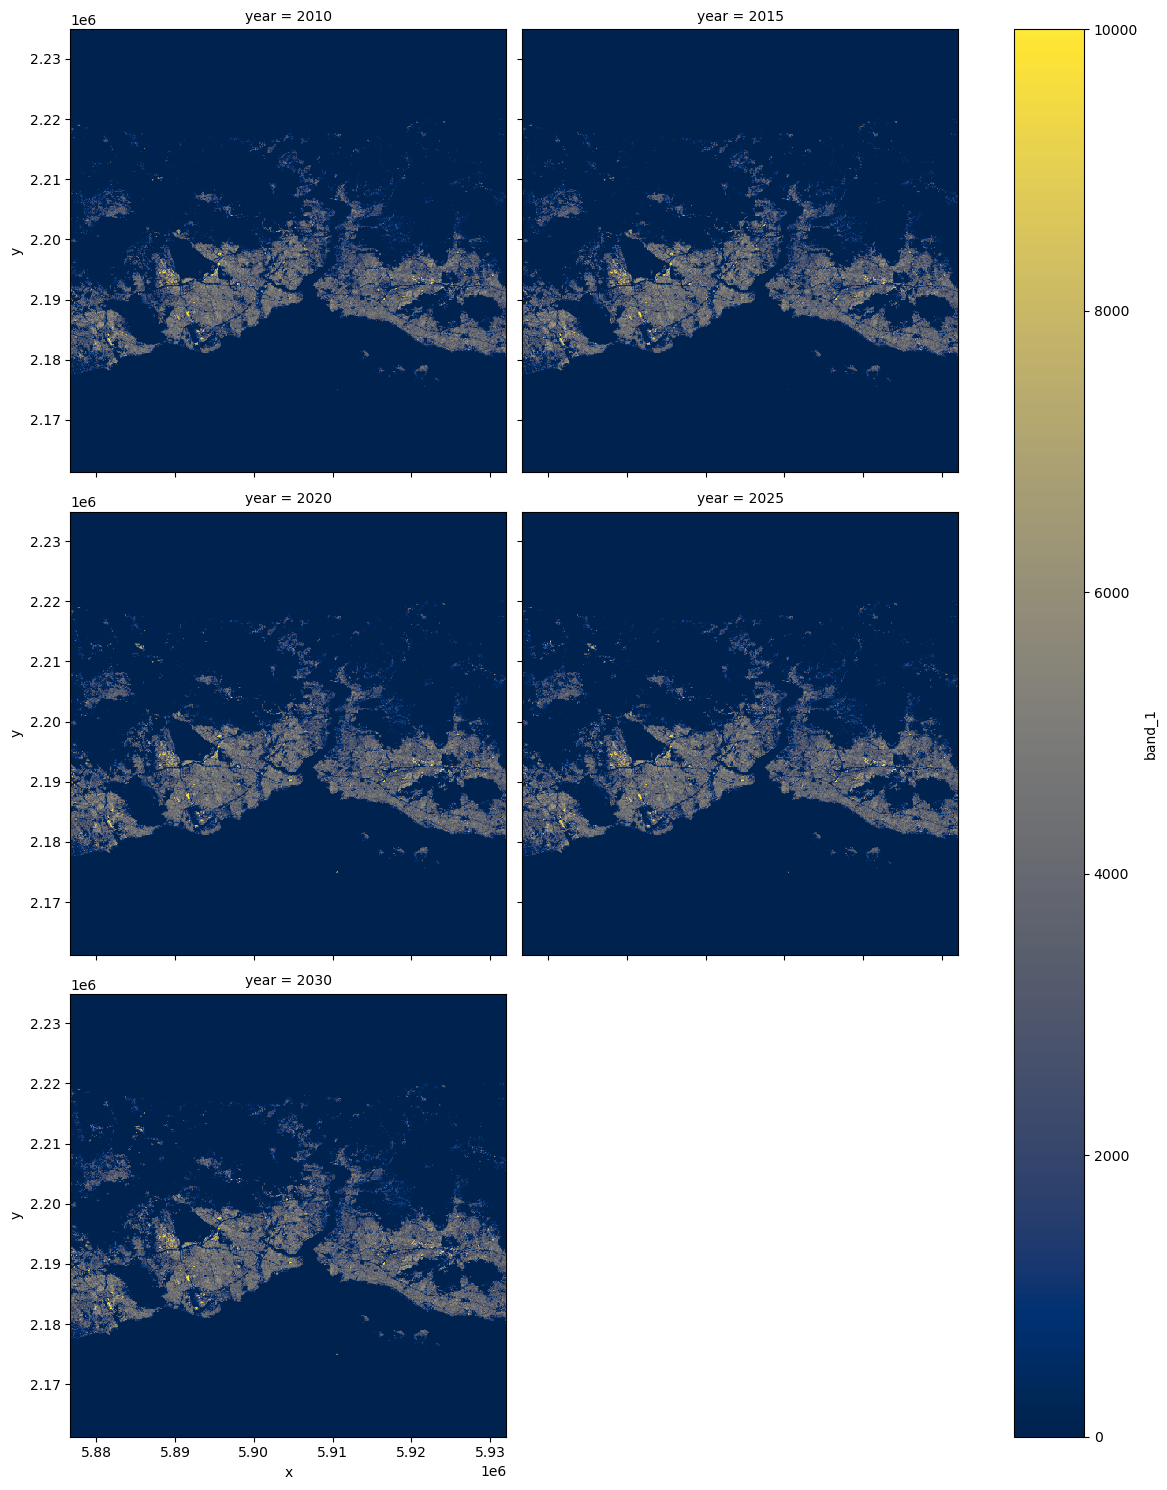

In [255]:
ds_ghs.band_1.plot(cmap="cividis", x="x", y="y", col="year", col_wrap=2, figsize=(12,15));

# Analysis
For analysis the first step is to classify the pixels. In our case we will just do a simple thresholding classification where we classify everything above 2000 as areas with moderate to high built-up surface. This isn't the best approach, but the purpose of this example is to demonstrate some basic analysis. More  comprehensive analysis can be done with these tools. 

This calculated mask with values above 2000 is then saved to a new Data Variable in the xarray dataset: 

In [246]:
ds_ghs["GHS_2000"] = ds_ghs.band_1 > 2000

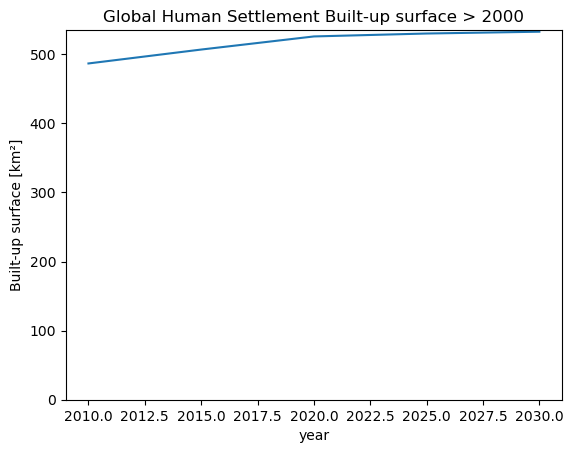

In [251]:
def to_km2(dataarray, resolution):
    # Calculate built up surface
    return dataarray * np.prod(list(resolution)) / 1e6 #convert area to km2


builtup_pixels = ds_ghs.GHS_2000.sum(["x", "y"])
builtup_area_km2 = to_km2(builtup_pixels, resolution)
builtup_area_km2.plot()
plt.title("Global Human Settlement Built-up surface > 2000")
plt.ylabel("Built-up surface [km²]")
plt.ylim(0);

We can see that the total GHS built-up surface in this AOI increased from 2010 to 2020, and it is expected that it will be slightly increasing in 2025 and 2030. 